Let's start by importing all the libraries we will use.

In [1]:
import numpy as np
from sklearn import manifold
from matplotlib import pyplot as plt
%matplotlib inline
# https://github.com/dribnet/lapjv1
import lapjv1
# https://github.com/src-d/lapjv
import lapjv

Now we create 2,025 3d points. 

In [2]:
side = 45
totalDataPoints = side * side
data3d = np.random.uniform(low=0.0, high=1.0, size=(totalDataPoints, 3))

And use sklearn's t-SNE implementation to create a 2d embedding.

In [3]:
tsne = manifold.TSNE(n_components=2, learning_rate=50)
%time data2d = tsne.fit_transform(data3d)

CPU times: user 14.9 s, sys: 1.16 s, total: 16.1 s
Wall time: 15.3 s


The output of t-SNE is not normalized, so we do that now. This isn't strictly necessary, but makes it easier to visualize the results of the assignment solution.

In [4]:
data2d -= data2d.min(axis=0)
data2d /= data2d.max(axis=0)

Let's plot the data using the 3d points as colors and 2d points for position.

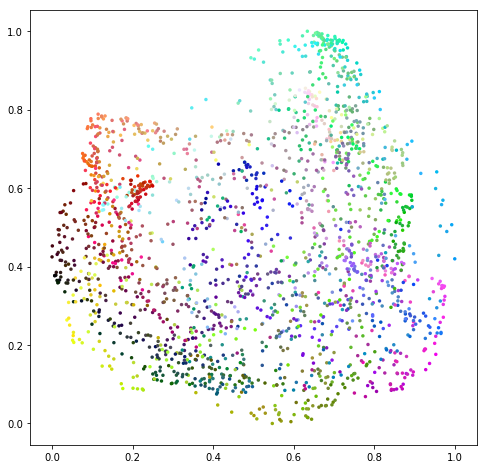

In [5]:
plt.figure(figsize=(8, 8))
plt.scatter(data2d[:,0], data2d[:,1], c=data3d, edgecolors='none', marker='o', s=12)  
plt.show()

Now let's make a list of grid points that we want to map our data onto.

In [6]:
xv, yv = np.meshgrid(np.linspace(0, 1, side), np.linspace(0, 1, side))
grid = np.dstack((xv, yv)).reshape(-1, 2)

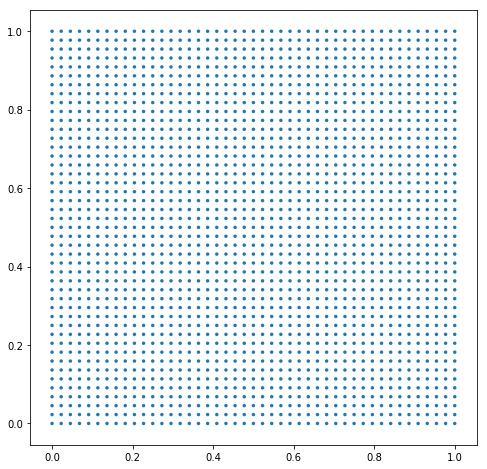

In [7]:
plt.figure(figsize=(8,8))
plt.scatter(grid[:,0], grid[:,1], edgecolors='none', marker='o', s=12)
plt.show()

Now we have two sets of 2d points.

In [7]:
print(grid.shape)
print(data2d.shape)

(2025, 2)
(2025, 2)


We evaluate a cost function that defines $n^2$ distances between the points. I like the results from the squared euclidean distance best.

CPU times: user 40 ms, sys: 0 ns, total: 40 ms
Wall time: 37.4 ms


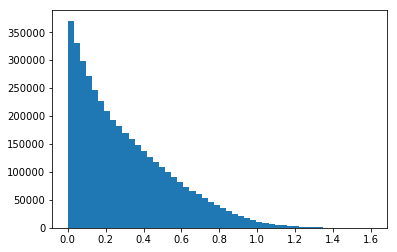

In [8]:
from scipy.spatial.distance import cdist
%time cost = cdist(grid, data2d, 'sqeuclidean')
plt.hist(cost.flatten(), bins=50)
plt.show()

After computing our cost matrix, it's super important to make the values of the cost matrix bigger. If any of the differences between two values in the cost matrix is too small, both the Hungarian algorithm and the JV algorithm can fail (and the JV algorithm is more likely to fail). Using the squared euclidean distance makes the JV algorithm more likely to fail than if you switch to the euclidean distance.

In [9]:
cost = cost * (100000. / cost.max())

Let's run the Hungarian algorithm on the cost matrix, take the results in `col_assign` to rearrange our `grid` list, and plot arrows from `data2d` to `grid_hu`. For 2k points it takes about 5 seconds on my laptop, and this implementation is $O(n^3)$.

Testing two different JV algorithms. Notice that we write `grid[col_assigns[:totalDataPoints]]`, this is because there is a [bug](https://github.com/hrldcpr/pyLAPJV/issues/1) with pyLAPJV that causes it to return very large arrays, and only the first part of the data is actually useful. On 2k points it takes about 45ms on my laptop.

CPU times: user 50.6 s, sys: 168 ms, total: 50.7 s
Wall time: 50.2 s
(2025,)


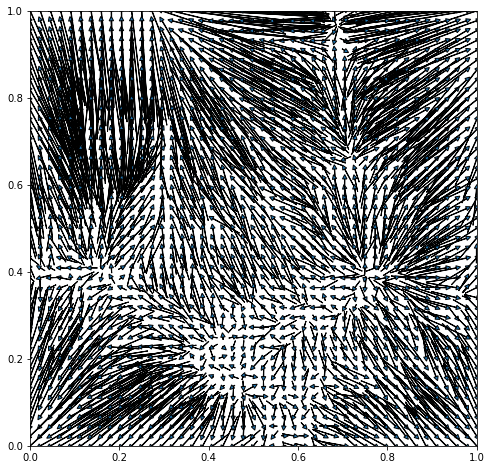

In [10]:
import lapjv1
%time min_cost, row_assigns1, col_assigns1 = lapjv1.lapjv1(cost)
grid_jv1 = grid[col_assigns1[:totalDataPoints]]
print(col_assigns1.shape)
plt.figure(figsize=(8, 8))
for start, end in zip(data2d, grid_jv1):
    plt.arrow(start[0], start[1], end[0] - start[0], end[1] - start[1],
              head_length=0.01, head_width=0.01)
plt.show()

CPU times: user 2.78 s, sys: 0 ns, total: 2.78 s
Wall time: 2.77 s
(2025,)


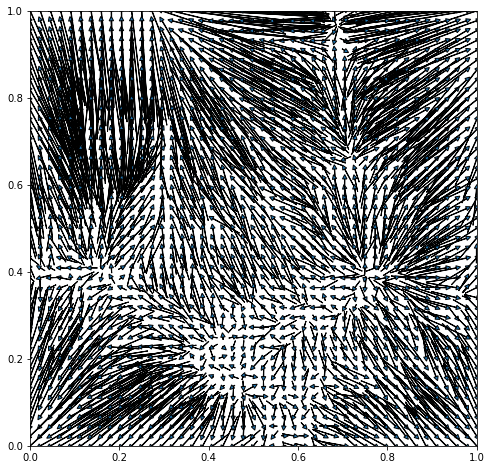

In [11]:
import lapjv
%time row_assigns2, col_assigns2, min_cost2 = lapjv.lapjv(cost, verbose=True, force_doubles=False)
grid_jv2 = grid[col_assigns2]
print(col_assigns2.shape)
plt.figure(figsize=(8, 8))
for start, end in zip(data2d, grid_jv2):
    plt.arrow(start[0], start[1], end[0] - start[0], end[1] - start[1],
              head_length=0.01, head_width=0.01)
plt.show()

Finally, let's plot the results of both on top of each other to visually verify that the results are equivalent.

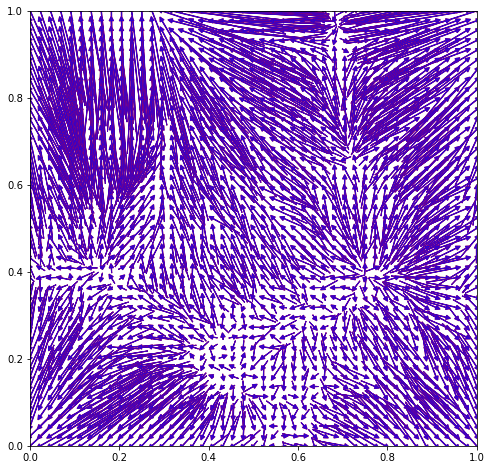

In [13]:
plt.figure(figsize=(8, 8))
for start, end_jv1, end_jv2 in zip(data2d, grid_jv1, grid_jv2):
    plt.arrow(start[0], start[1], end_jv1[0] - start[0], end_jv1[1] - start[1],
              head_length=0.01, head_width=0.01, color='red')
    plt.arrow(start[0], start[1], end_jv2[0] - start[0], end_jv2[1] - start[1],
              head_length=0.01, head_width=0.01, color='blue', alpha=0.7)
plt.show()